# Imports

In [1]:
# Basics
import pandas as pd
import numpy as np
np.random.seed(0)
from matplotlib import pyplot as plt
import seaborn as sns

# Job database wrapper
from JobsDb import JobsDb

# Text preprocessing
from keras.preprocessing import text, sequence

# Clustering tools 
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import calinski_harabasz_score

# Vectorizing Tools
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Classification Tools
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, GlobalMaxPool1D

# Pipeline tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier

# Model evaluation
from sklearn.metrics import confusion_matrix

# Load Data

In [2]:
def load_data():
    db = JobsDb()
    df = db.load_table_as_df('jobs')
    db.close()
    return df

df = load_data()
#df = df.iloc[9800:]
df.head()

,id,title,url,description
0,1,Psychiatrist (Per Diem) - #201222-4667HD,https://www.careerjet.com/jobad/us61b2e1c18a4d...,\n \n shall strive to be a global leader i...
1,2,Professor of Osteopathic Manipulative Medicine,https://www.careerjet.com/jobad/us0f769e5a939c...,\nPosition Details Position Title Professor o...
2,3,Amazon Warehouse Assistant - Immediately Hiring,https://www.careerjet.com/jobad/usba95a3670331...,\n \n Hourly pay rate: $15.00 *The base pa...
3,4,Non-QM Underwriter,https://www.careerjet.com/jobad/usb59eda9438ed...,\nJob Description We looking to add an experi...
4,5,"project manager, accounting systems",https://www.careerjet.com/jobad/us71cfd31d23d6...,\njob description job summary: Project Manag...


# Cluster Analysis of Titles

## Extract Titles and Descriptions 

In [3]:
def extract_data(df):
    titles = df['title']
    descriptions = df['description']
    return titles, descriptions

titles, descriptions = extract_data(df)

## Compute Title Vocabulary

In [4]:
def get_vocabulary(titles):
    vocabulary = set(word for title in titles for word in title.split(' '))
    return vocabulary

title_vocabulary = get_vocabulary(titles)
description_vocabulary = get_vocabulary(descriptions)

## Vectorize Vocabulary

In [5]:
def vectorize_vocabulary(vocabulary):
    glove = {}
    with open('../model/glove.6B.50d.txt', 'rb') as f:
        for line in f:
            parts = line.split()
            word = parts[0].decode('utf-8')
            if word in vocabulary:
                vector = np.array(parts[1:], dtype=np.float32)
                glove[word] = vector
    return glove

title_glove = vectorize_vocabulary(title_vocabulary)
description_glove = vectorize_vocabulary(description_vocabulary)

## Title Vectorizer Class

In [6]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])
    
title_vectorizer = W2vVectorizer(title_glove)

## Build Vector Clustering Pipeline

In [7]:
cluster_pipe =  Pipeline([
    ('Word2Vec_Vectorizer', title_vectorizer),
    ('KMeans', KMeans(n_clusters=5))])

## Fit Pipeline on Titles

In [8]:
cluster_pipe.fit(titles)

Pipeline(steps=[('Word2Vec_Vectorizer',
                 <__main__.W2vVectorizer object at 0x7f14a7c7ac50>),
                ('KMeans', KMeans(n_clusters=5))])

## Build Target Classes

In [9]:
target = cluster_pipe.predict(titles)

# Class Distribution

<AxesSubplot:>

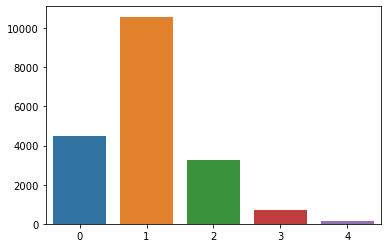

In [11]:
classes, class_counts = np.unique(target, return_counts=True)
sns.barplot(x=classes, y=class_counts)

# Deep NLP Model to Classify Descriptions 

## Word Vectorizer for Descriptions

In [12]:
model_folder = '/home/schart/Flatiron/DataScience/Phase5/Assessments/JobDash/model/'
glove_file = datapath(model_folder +'glove.6B.50d.txt')
tmp_file = get_tmpfile(model_folder+'glove_to_w2vec.txt')
_ = glove2word2vec(glove_file, tmp_file)
model_glove = KeyedVectors.load_word2vec_format(tmp_file)

## Preprocessor for Descriptions 

In [13]:
def preprocess_descriptions(X):
    tokenizer = text.Tokenizer(num_words=20000)
    tokenizer.fit_on_texts(list(X))
    list_tokenized_descriptions = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(list_tokenized_descriptions, maxlen=500)
    return X

preprocessor = FunctionTransformer(preprocess_descriptions)

## Build Classifier

In [15]:
def build_classifier():
    classifier = Sequential()
    embedding_size = 128
    #classifier.add(Embedding(20000, embedding_size))
    classifier.add(model_glove.get_keras_embedding())
    classifier.add(LSTM(50, return_sequences=False))
    classifier.add(Dense(50, activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(5, activation='softmax'))
    classifier.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )   
    return classifier

classifier = KerasClassifier(
    build_fn=build_classifier, 
    epochs=3, 
    batch_size=32, 
    validation_split=0.1,
    workers=4
)

## Build Classifier Pipeline

In [16]:
classifier_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ]
)

## Fit Classifier Pipeline

In [17]:
classifier_pipe.fit(descriptions, target)

Epoch 1/3
539/539 [==============================] - 288s 535ms/step - loss: 0.9859 - accuracy: 0.6074 - val_loss: 0.8082 - val_accuracy: 0.7152
Epoch 2/3
539/539 [==============================] - 287s 533ms/step - loss: 0.8363 - accuracy: 0.6698 - val_loss: 0.8088 - val_accuracy: 0.7355
Epoch 3/3
539/539 [==============================] - 283s 525ms/step - loss: 0.8073 - accuracy: 0.6821 - val_loss: 0.7759 - val_accuracy: 0.7376


Pipeline(steps=[('preprocessor',
                 FunctionTransformer(func=<function preprocess_descriptions at 0x7f14aae1f510>)),
                ('classifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f148c9d07f0>)])

# Make Predictions

In [18]:
pred = classifier_pipe.predict(descriptions)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


# Confusion Matrix

In [19]:
confmat = confusion_matrix(target, pred)

<AxesSubplot:>

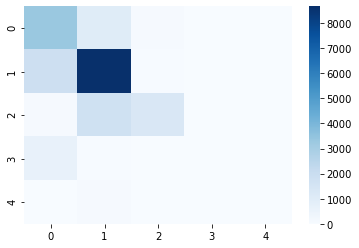

In [20]:
sns.heatmap(confmat, cmap='Blues')